# DeepSORVF: Deep Learning-based Simple Online and Real-Time Vessel Data Fusion Method

DeepSORVF is an AIS and video data fusion method.

## 1. Environment Set-up

In [1]:
!pip install datetime pandas matplotlib fastdtw imutils geopy pyproj easydict opencv-python

  Using cached DateTime-5.5-py3-none-any.whl.metadata (33 kB)
  Using cached zope.interface-7.2-cp311-cp311-win_amd64.whl.metadata (45 kB)
Using cached DateTime-5.5-py3-none-any.whl (52 kB)
Using cached zope.interface-7.2-cp311-cp311-win_amd64.whl (212 kB)

   ---------------------------------------- 0/2 [zope.interface]
   ---------------------------------------- 2/2 [datetime]



Select the appropriate version of pytorch.

In [2]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


ERROR: Could not find a version that satisfies the requirement torch==1.13.1+cu117 (from versions: 2.0.0, 2.0.0+cu117, 2.0.1, 2.0.1+cu117, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.13.1+cu117


In [3]:
import torch
torch.__version__

'2.8.0+cpu'

## 2. Download Model

Download [ckpt.t7](https://drive.google.com/file/d/1QdIP5TEDALJnnpqwjXwvL1J_GoseTK9D/view?usp=share_link) and save to `DeepSORVF/deep_sort/deep_sort/deep/checkpoint/` folder. Download [YOLOX-final.pth](https://drive.google.com/file/d/1mhah7ZzP8oAUuSMR96Or9UvqkXe-AMuS/view?usp=share_link) and save to `DeepSORVF/detection_yolox/model_data/` folder.

## 3. Download Data

Download sample data [clip-01](https://drive.google.com/file/d/1Bns1jAW1ImL-FeCQBvIUcrO0hjYLIB5K/view?usp=share_link).

## 4. Visualize Data

In [4]:
# Video Data
import cv2, imutils
cap = cv2.VideoCapture('./clip-01/2022_06_04_12_05_12_12_07_02_b.mp4')

_, im = cap.read()
result = imutils.resize(im, height=500)

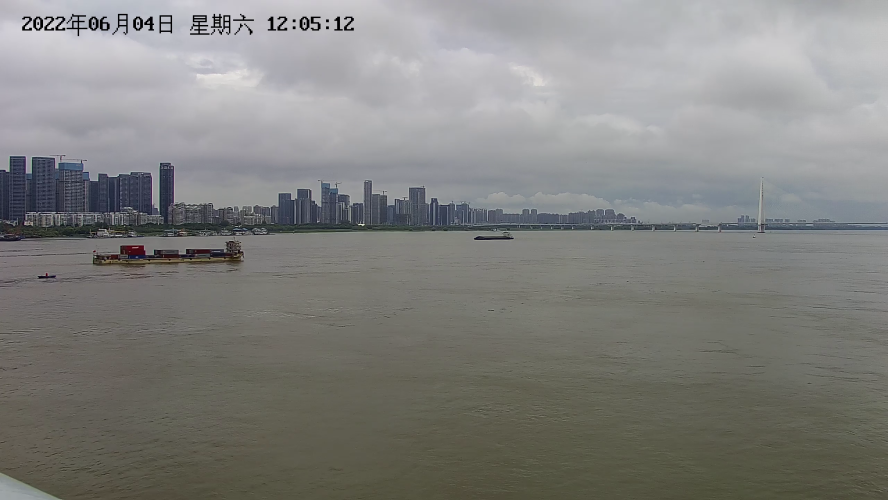

In [7]:
from PIL import Image

Image.fromarray(result[:,:,::-1])

In [8]:
# camera parameters
import glob
with open(glob.glob('./clip-01/camera_para.txt')[0], "r") as f:
    camera_para = f.readlines()[0][1:-2]
    camera_para = camera_para.split(',')
    camera_para = list(map(float,camera_para))

In [9]:
camera_para

[114.32722222222222,
 30.60027777777778,
 352.0,
 -4.0,
 20.0,
 55.0,
 30.94,
 2391.26,
 2446.89,
 1305.04,
 855.21]

In [14]:
import pandas as pd
from pathlib import Path

ais_dir = Path('./clip-01/ais')
df_list = []

for csv_file in sorted(ais_dir.glob("*.csv")):
    df = pd.read_csv(csv_file, usecols=[1, 2, 3, 4, 5, 6, 7, 8], header=0)
    df_list.append(df)

ais_data = pd.concat(df_list, ignore_index=True)

# Video ile AIS zamanlarını hizala
offset = timestamp0 - ais_data['timestamp'].min()
ais_data['timestamp'] += offset

print(ais_data.shape)
print(ais_data.head())

(3046, 8)
        mmsi         lon        lat  speed  course  heading  type  \
0  110000000  114.325830  30.601158    0.9   142.5      511    18   
1  130000000  114.319323  30.615373    0.1   120.0      203     3   
2  140000000  114.332392  30.616292    8.4    48.1      511    18   
3  150000000  114.307825  30.596593    2.8   222.5      511    18   
4  160000000  114.317922  30.614342    0.0     0.0      511    18   

       timestamp  
0  1654334058571  
1  1654333979434  
2  1654333575738  
3  1654334062289  
4  1654333848622  


In [15]:
ais_data

,mmsi,lon,lat,speed,course,heading,type,timestamp
0,110000000,114.325830,30.601158,0.9,142.5,511,18,1654334058571
1,130000000,114.319323,30.615373,0.1,120.0,203,3,1654333979434
2,140000000,114.332392,30.616292,8.4,48.1,511,18,1654333575738
3,150000000,114.307825,30.596593,2.8,222.5,511,18,1654334062289
4,160000000,114.317922,30.614342,0.0,0.0,511,18,1654333848622
...,...,...,...,...,...,...,...,...
3041,380000000,114.327205,30.611592,7.8,41.8,0,18,1654334205575
3042,410000000,114.292763,30.573643,3.2,208.8,511,18,1654333944537
3043,430000000,114.297373,30.581763,0.0,267.0,511,18,1654334038455
3044,440000000,114.320200,30.616823,0.0,360.0,185,1,1654334205575


## 5. Start Running

In [3]:
import os, time, imutils, cv2, argparse
import pandas as pd
import numpy as np

# read data
from utils.file_read import read_all, ais_initial, update_time, time2stamp

# AIS Video Fusion package
from utils.AIS_utils import AISPRO
from utils.VIS_utils import VISPRO
from utils.FUS_utils import FUSPRO

# Show the fusion results on the Video
from utils.draw import DRAW

# Save the detection tracking and fusion files
from utils.gen_result import gen_result


detection_yolox/model_data/YOLOX-final.pth model, and classes loaded.


In [10]:
# Parameter Settings
data_path = './clip-01/'
result_path = './result/'
anti = 1
anti_rate = 0
video_path, ais_path, result_video, result_metric, initial_time,\
      camera_para = read_all(data_path, result_path)

ais_path = "./clip-01/ais"

# Initialization
ais_file, timestamp0, time0 = ais_initial(ais_path, initial_time)
print("timestamp0:", timestamp0)

# AIS timestamp'larını video zamanına hizala
from pathlib import Path
import pandas as pd

ais_dir = Path(ais_path)
offset = timestamp0 - pd.read_csv(sorted(ais_dir.glob("*.csv"))[0])['timestamp'].min()

for csv_file in ais_dir.glob("*.csv"):
    df = pd.read_csv(csv_file)
    df['timestamp'] += offset
    df.to_csv(csv_file, index=False)

Time = initial_time.copy()

cap = cv2.VideoCapture(video_path)
im_shape = [cap.get(3), cap.get(4)]
max_dis = min(im_shape)//2
fps = int(cap.get(5))
t = int(1000/fps)
    
AIS = AISPRO(ais_path, ais_file, im_shape, t) # ais path, ais file, im_shape, t
VIS = VISPRO(anti, anti_rate, t) # anti-occlusion, occlusion rate, t
FUS = FUSPRO(max_dis, im_shape, t) # max distance of matching, im_shape, t
DRA = DRAW(im_shape, t) # im_shape, t
    
name = 'demo'
show_size = 500
videoWriter = None
bin_inf = pd.DataFrame(columns=['ID', 'mmsi', 'timestamp', 'match'])

print('Start Time: %s || Stamp: %d || fps: %d' % (time0, timestamp0, fps))
times  = 0
time_i = 0
sum_t  = []


timestamp0: 1654333512000
Start Time: 2022_06_04_12_05_12_000 || Stamp: 1654333512000 || fps: 25


In [ ]:
# running
while True:
    # read frame
    _, im = cap.read()
    if im is None:
        break
    start = time.time()
        
    # update timestamp
    Time, timestamp, Time_name = update_time(Time, t)
    # =============================================================================
    #  1.AIS-based trajectory extraction. The AIS data is updated every second
    # =============================================================================
    AIS_vis, AIS_cur = AIS.process(camera_para, timestamp, Time_name)
    # =============================================================================
    #  2.Video-based trajectory extraction.
    # =============================================================================
    Vis_tra, Vis_cur = VIS.feedCap(im, timestamp, AIS_vis, bin_inf)
    # =============================================================================
    #  3.AIS/Video fusion
    # =============================================================================
    Fus_tra, bin_inf = FUS.fusion(AIS_vis, AIS_cur, Vis_tra, Vis_cur, timestamp)

    end = time.time() - start
    time_i = time_i + end
    if timestamp % 1000 < t:
        # Generate detection.txt tracking.txt fusion.txt
        gen_result(times, Vis_cur, Fus_tra, result_metric, im_shape)
        times = times+1
        sum_t.append(time_i)
        print('Time: %s || Stamp: %d || Process: %.6f || Average: %.6f +- %.6f'%(Time_name, timestamp, time_i, np.mean(sum_t), np.std(sum_t)))
        time_i = 0
    # =============================================================================
    #  4.Fusion result visualization
    # =============================================================================
    im = DRA.draw_traj(im, AIS_vis, AIS_cur, Vis_tra, Vis_cur, Fus_tra, timestamp)
    # =============================================================================
    #  Video display
    # =============================================================================
    result = im
    result = imutils.resize(result, height=show_size)
    if videoWriter is None:
        fourcc = cv2.VideoWriter_fourcc(
                'm', 'p', '4', 'v')
        videoWriter = cv2.VideoWriter(
                result_video, fourcc, fps, (result.shape[1], result.shape[0]))

    videoWriter.write(result)

    cv2.imshow(name, result)
    cv2.waitKey(1)
    if cv2.getWindowProperty(name, cv2.WND_PROP_AUTOSIZE) < 1:
    # x exist
        break   
cap.release()
videoWriter.release()
cv2.destroyAllWindows()

Time: 2022_06_04_12_05_13_000 || Stamp: 1654333513000 || Process: 2.903707 || Average: 2.903707 +- 0.000000
Time: 2022_06_04_12_05_14_000 || Stamp: 1654333514000 || Process: 2.862957 || Average: 2.883332 +- 0.020375
Time: 2022_06_04_12_05_15_000 || Stamp: 1654333515000 || Process: 2.873694 || Average: 2.880119 +- 0.017245
Time: 2022_06_04_12_05_16_000 || Stamp: 1654333516000 || Process: 2.895641 || Average: 2.884000 +- 0.016377
Time: 2022_06_04_12_05_17_000 || Stamp: 1654333517000 || Process: 2.971406 || Average: 2.901481 +- 0.037907
Time: 2022_06_04_12_05_18_000 || Stamp: 1654333518000 || Process: 2.943249 || Average: 2.908442 +- 0.037944
Time: 2022_06_04_12_05_19_000 || Stamp: 1654333519000 || Process: 2.869643 || Average: 2.902899 +- 0.037662
Time: 2022_06_04_12_05_20_000 || Stamp: 1654333520000 || Process: 2.897191 || Average: 2.902186 +- 0.035280
Time: 2022_06_04_12_05_21_000 || Stamp: 1654333521000 || Process: 2.920222 || Average: 2.904190 +- 0.033742
Time: 2022_06_04_12_05_22_00

KeyboardInterrupt: 

: 

In [13]:
print("Video start:", timestamp0)
print("AIS start:", ais_data['timestamp'].min())
print("Fark (saniye):", (timestamp0 - ais_data['timestamp'].min())/1000)


Video start: 1654333512000
AIS start: 1654314955433
Fark (saniye): 18556.567
